## <center><strong>Imports and Configurations</strong></center>

In [1]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
from datasets import Dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from tqdm import tqdm, trange
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import nltk
# nltk.download("punkt")

In [3]:
# Available device and GPU count
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Available device: ", device)
device_count = torch.cuda.device_count()
print("Number of available GPU: ", device_count)
if device_count > 0:
    print("Avialable GPUs: ")
for i in range(device_count):
    print(torch.cuda.get_device_name(i), end=' ')

Available device:  cuda
Number of available GPU:  3
Avialable GPUs: 
NVIDIA GeForce RTX 3090 NVIDIA GeForce RTX 3090 NVIDIA GeForce RTX 3090 

In [4]:
# Configurations
configs = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'data_path': 'learning-agency-lab-automated-essay-scoring-2/train.csv',
    'eval_path': 'learning-agency-lab-automated-essay-scoring-2/test.csv',
    'save_path': 'models',
    'n_labels': 6,
    'tokenizer_name': 'roberta',
    'model_name': 'roberta',
    'MAX_LENGTH': 512,
    'BATCH_SIZE': 32,
    'EPOCHS': 50,
    'patience': 8,
    'learning_rate': 2e-5,
    'weight_decay': 0.001
}

## <center><strong>Read Data</strong></center>

In [5]:
# Read data
df = pd.read_csv(configs['data_path'])
df.drop(columns='essay_id', inplace=True)
df.rename(columns={'full_text': 'text', 'score': 'label'}, inplace=True)
df.head()

,text,label
0,Many people have car where they live. The thin...,3
1,I am a scientist at NASA that is discussing th...,3
2,People always wish they had the same technolog...,4
3,"We all heard about Venus, the planet without a...",4
4,"Dear, State Senator\n\nThis is a letter to arg...",3


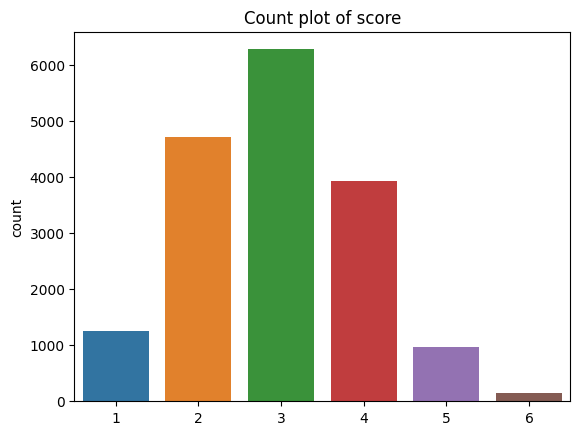

In [6]:
# Countplot of scores
sns.countplot(x=df['label'].to_list())
plt.title('Count plot of score')
plt.show()

<p>From the above graph, it's clear that if the problem is treated as a classification problem then the classification will be a imbalanced classification. Some sampling technique should be introduced to handle the imbalance issue.</p>

100%|██████████| 17307/17307 [00:35<00:00, 487.27it/s]


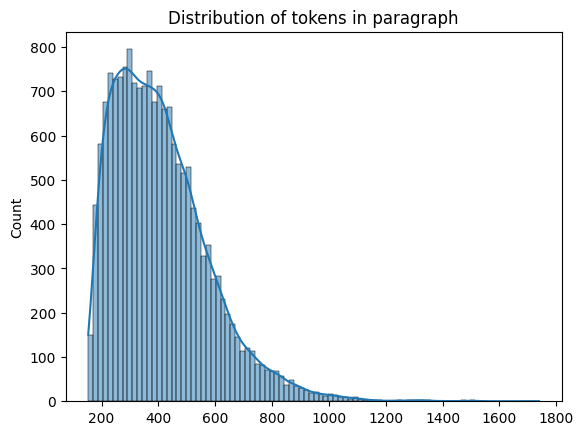

In [7]:
# Check distribution of number of taokens
n_tokens = df['text'].progress_apply(lambda x: len(word_tokenize(x))).to_list()
sns.histplot(n_tokens, kde=True)
plt.title('Distribution of tokens in paragraph')
plt.show()

<pp>There are less representation of sentence of length more than 600. So, there is a high chance that the model doesn't generalize well for data like larger sentences.<p>

## <center><strong>Split Data</strong></center>

In [8]:
df.head()

,text,label
0,Many people have car where they live. The thin...,3
1,I am a scientist at NASA that is discussing th...,3
2,People always wish they had the same technolog...,4
3,"We all heard about Venus, the planet without a...",4
4,"Dear, State Senator\n\nThis is a letter to arg...",3


In [11]:
# Split into train, val and test set
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df.label.values, random_state=32)
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df.label.values, random_state=32)

In [12]:
# Create dataset from dataframe
dataset = DatasetDict()
dataset['train'] = Dataset.from_pandas(train_df)
dataset['val'] = Dataset.from_pandas(val_df)
dataset['test'] = Dataset.from_pandas(test_df)
dataset = dataset.remove_columns('__index_level_0__')
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 13845
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 1731
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1731
    })
})

## <center><strong>Data Preprocessing</strong></center>

In [13]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(configs['tokenizer_name'])

In [14]:
# Tokenize sentences
def tokenize(data):
    return tokenizer(data['text'], max_length=configs['MAX_LENGTH'], padding=True, truncation=True)

dataset['train'] = dataset['train'].map(tokenize, batched=True, batch_size=configs['BATCH_SIZE'])
dataset['val'] = dataset['val'].map(tokenize, batched=True, batch_size=configs['BATCH_SIZE'])

Map:   0%|          | 0/13845 [00:00<?, ? examples/s]

Map:   0%|          | 0/1731 [00:00<?, ? examples/s]

In [15]:
# Encode lables
def encode(data):
    data['label'] = np.eye(configs['n_labels'])[np.array(data['label']) - 1]
    return data

dataset['train'] = dataset['train'].map(encode, batched=True, batch_size=configs['BATCH_SIZE'])
dataset['val'] = dataset['val'].map(encode, batched=True, batch_size=configs['BATCH_SIZE'])

Map:   0%|          | 0/13845 [00:00<?, ? examples/s]

Map:   0%|          | 0/1731 [00:00<?, ? examples/s]

## <center><strong>Train Model</strong></center>

In [16]:
# Load Model
model = AutoModelForSequenceClassification.from_pretrained(configs['model_name'], num_labels=configs['n_labels'],ignore_mismatched_sizes = True)
model = model.to(device)
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [17]:
# Define training arguments
args = TrainingArguments(
    configs['save_path'],
    evaluation_strategy='epoch',
    eval_steps=1,
    logging_strategy='epoch',
    logging_steps=1,
    logging_dir=os.path.join(configs['save_path'],'logs'),
    save_strategy = "epoch",
    save_steps=1,
    save_total_limit=3,
    num_train_epochs=configs['EPOCHS'],
    per_device_train_batch_size=configs['BATCH_SIZE'],
    per_device_eval_batch_size=configs['BATCH_SIZE'],
    learning_rate=configs['learning_rate'],
    weight_decay=configs['weight_decay'],
    metric_for_best_model='eval_loss',
    load_best_model_at_end=True,
    report_to='tensorboard'
)

In [18]:
# Declare a evaluation metric
metric = load_metric('accuracy')
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    references = np.argmax(labels, axis=-1)
    return metric.compute(predictions=predictions, references=references)

In [19]:
# Initialize trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['val'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = configs['patience'])]
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [20]:
# Start training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.355900,0.292738,0.596765
2,0.281000,0.272886,0.593876
3,0.256400,0.287080,0.582900


## <center><strong>Evaluate Model</strong></center>

In [18]:
# Evaluate model on text
predictions, labels = [], []
for i in trange(len(dataset['test']['text']), desc='Evaluating'):
    text = dataset['test']['text'][i]
    label = dataset['test']['label'][i]
    inputs = tokenizer(text, max_length=configs['MAX_LENGTH'], padding=True, truncation=True, return_tensors='pt').to(device)
    outputs = model(**inputs)
    pred = np.argmax(outputs['logits'].to('cpu').detach().numpy(), axis=-1)[0] + 1
    predictions.append(pred)
    labels.append(label)

Evaluating: 100%|██████████| 1731/1731 [00:30<00:00, 55.89it/s]


In [19]:
# Calcultae classification report
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           1       0.82      0.30      0.44       125
           2       0.66      0.68      0.67       473
           3       0.63      0.66      0.65       628
           4       0.57      0.69      0.62       393
           5       0.46      0.30      0.36        97
           6       0.00      0.00      0.00        15

    accuracy                           0.62      1731
   macro avg       0.52      0.44      0.46      1731
weighted avg       0.62      0.62      0.61      1731



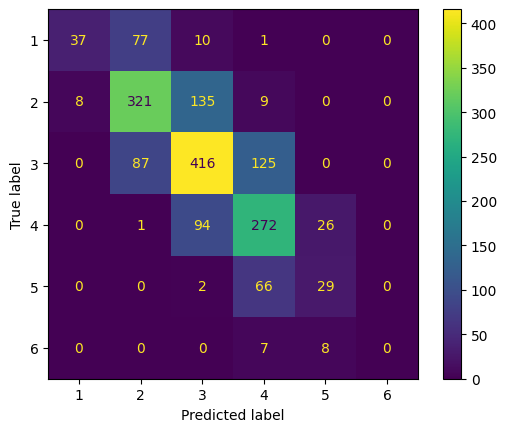

In [20]:

# Plot confusion matrix
cm = confusion_matrix(labels, predictions, labels=list(set(labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(labels)))
disp.plot()
plt.show()

In [21]:
model.save_pretrained(f'{configs["model_name"]}result')

## <center><strong>Conclusion</strong></center>

<p>In many instances, we observe significant overlap among nearby classes, which presents a considerable challenge. Addressing this issue promises substantial improvements in performance metrics. One effective approach involves augmenting the dataset by generating new data or applying data augmentation techniques. By increasing the number of samples, deep learning models gain a clearer understanding of the distinctions between various classes within the vector space. Notably, the performance metrics exhibit a particularly poor score of 6. This deficiency can be attributed to the scarcity of data points available for this specific class.</p>